# Surgery Pipeline for PBMC dataset with all models

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
url = 'https://drive.google.com/uc?id=1EJaoOtMQRaeCzErjts2sH2THXi0seoFl'
output = 'human_pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1EJaoOtMQRaeCzErjts2sH2THXi0seoFl
To: /home/marco/Documents/git_repos/scarches/human_pbmc.h5ad
517MB [00:04, 114MB/s]  


'human_pbmc.h5ad'

In [5]:
adata_all = sc.read('human_pbmc.h5ad')

In [6]:
condition_key = "study"
cell_type_key = "CellType"

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)

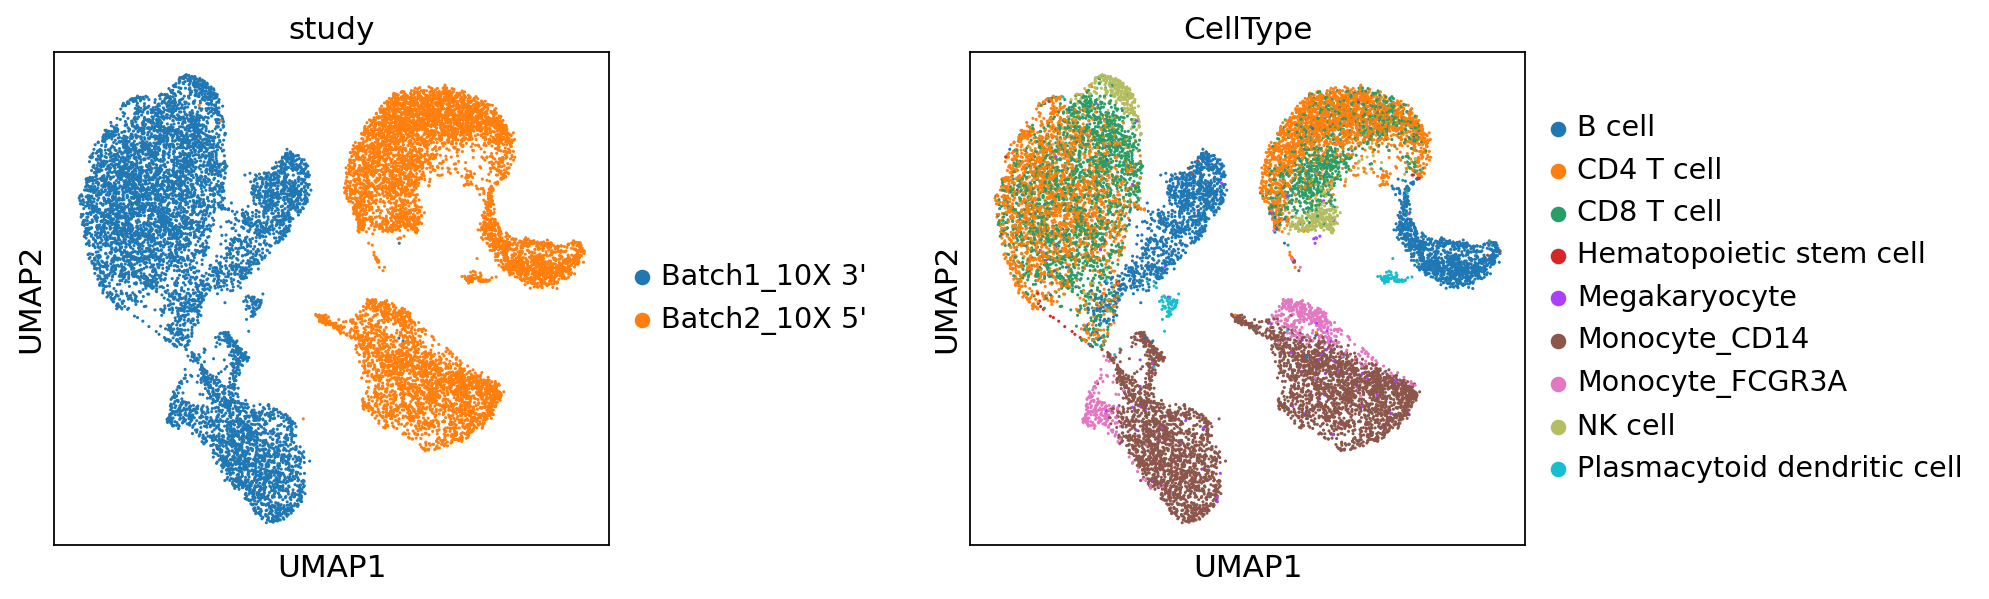

In [8]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

In [9]:
target_conditions = ["Batch2_10X 5'"]
orig_source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
orig_target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = orig_source_adata.obs[condition_key].unique().tolist()

In [10]:
orig_source_adata

View of AnnData object with n_obs × n_vars = 8098 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [11]:
orig_target_adata

View of AnnData object with n_obs × n_vars = 7378 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

### Surgery pipeline for TRVAE model

In [17]:
source_adata = orig_source_adata.copy()
target_adata = orig_target_adata.copy()

Create the TRVAE model instance.

In [18]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



Train the TRVAE model instance.

In [19]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
trvae.train(
    n_epochs=500,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█████---------------| 25.4%  - epoch_loss:    1459 - epoch_recon_loss:    1452 - epoch_kl_loss:      10 - val_loss:    1424 - val_recon_loss:    1417 - val_kl_loss:      10
ADJUSTED LR
 |█████---------------| 26.8%  - epoch_loss:    1442 - epoch_recon_loss:    1435 - epoch_kl_loss:      10 - val_loss:    1448 - val_recon_loss:    1441 - val_kl_loss:      10
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 112


Show latent representation of reference data.

In [20]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


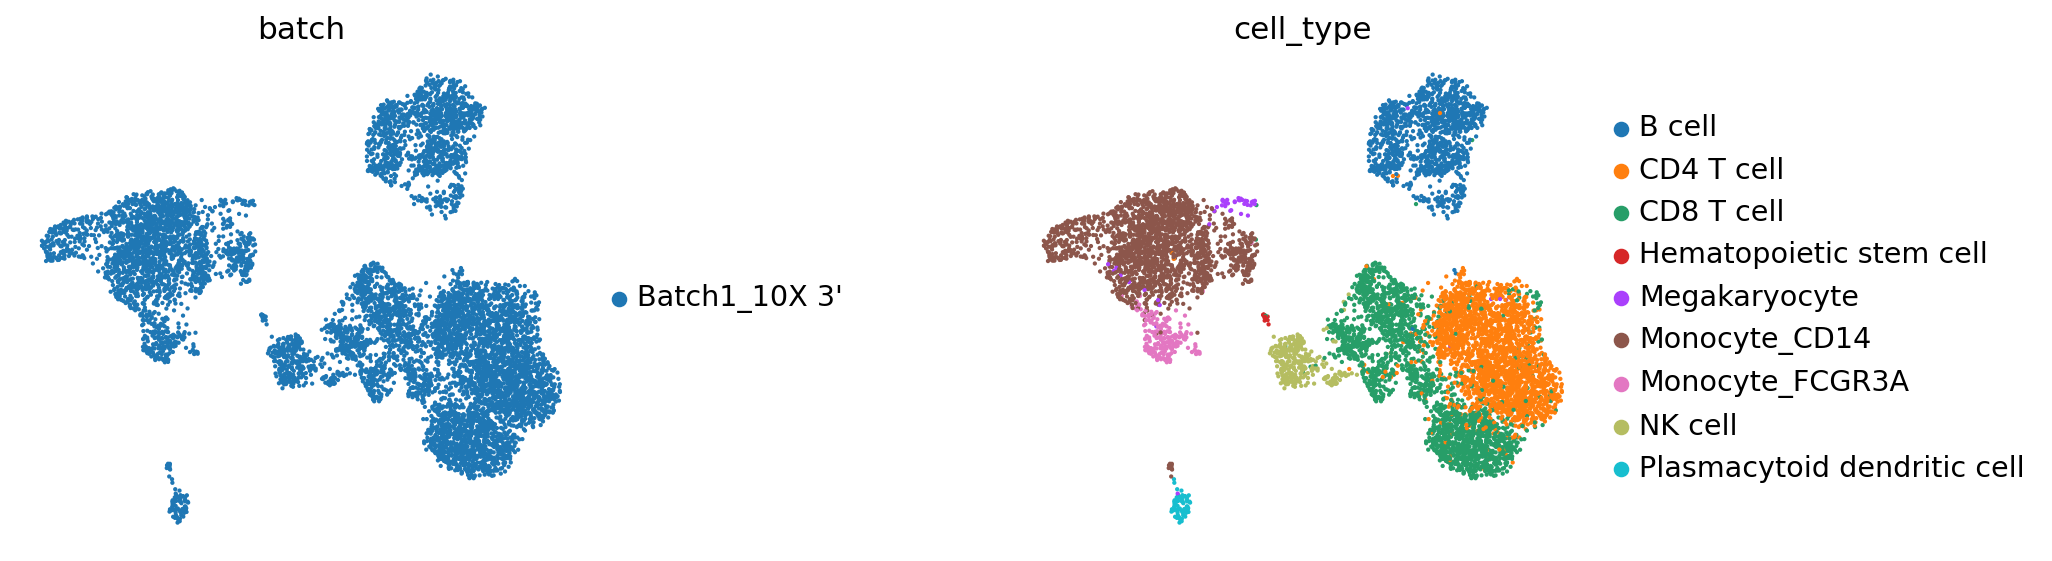

In [21]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

Do architecture surgery with the query dataset.

In [25]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=trvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [26]:
new_trvae.train(
    n_epochs=500,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█████████-----------| 49.8%  - epoch_loss:    2091 - epoch_recon_loss:    2081 - epoch_kl_loss:       9 - val_loss:    2029 - val_recon_loss:    2019 - val_kl_loss:       9
ADJUSTED LR
 |██████████----------| 54.6%  - epoch_loss:    2057 - epoch_recon_loss:    2048 - epoch_kl_loss:       9 - val_loss:    2017 - val_recon_loss:    2008 - val_kl_loss:       9
ADJUSTED LR
 |███████████---------| 56.0%  - epoch_loss:    2031 - epoch_recon_loss:    2022 - epoch_kl_loss:       9 - val_loss:    2024 - val_recon_loss:    2015 - val_kl_loss:       9
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 258


Show latent representation of query dataset.

In [27]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


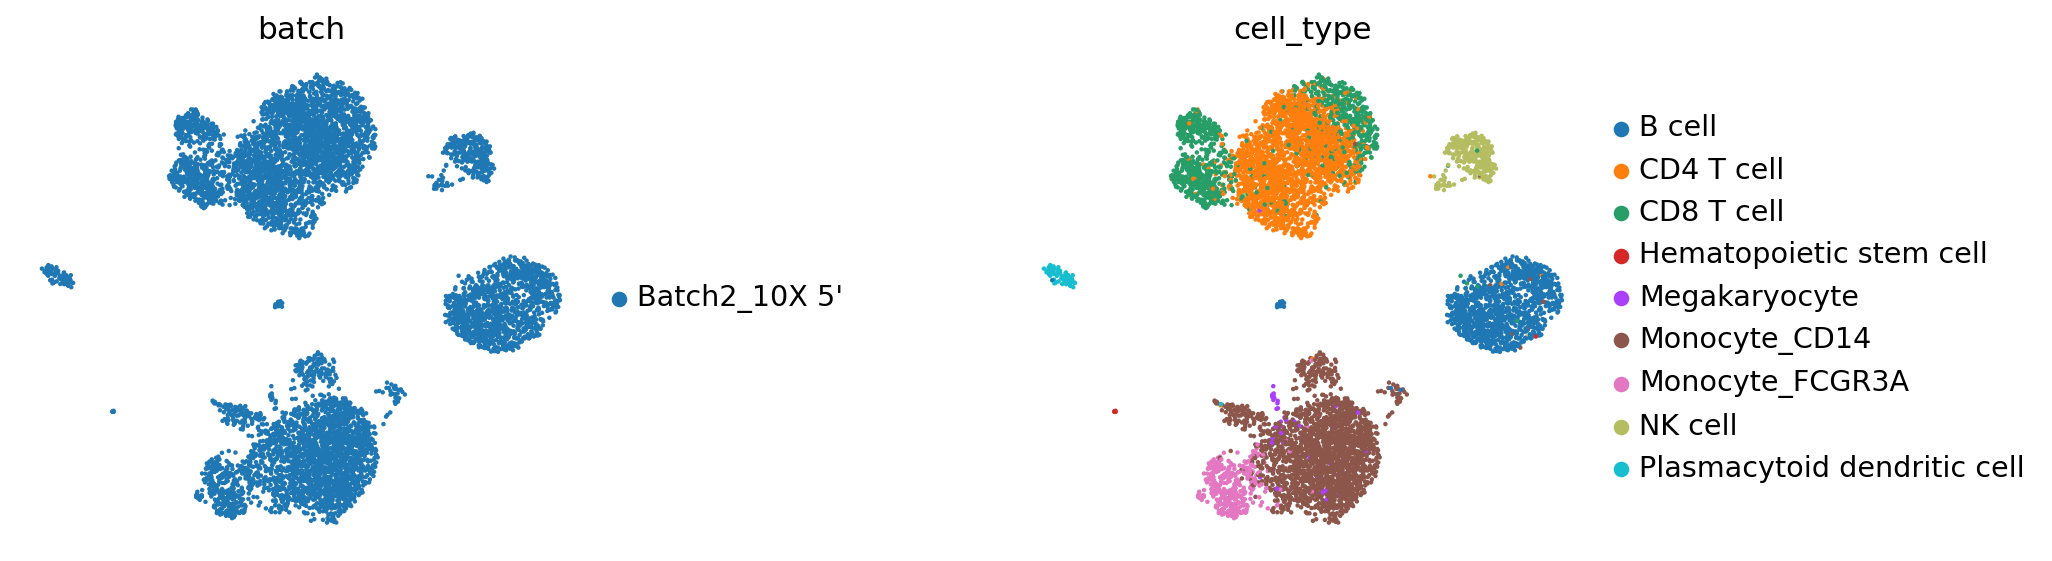

In [28]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

Show latent representation of reference + query dataset.

In [29]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


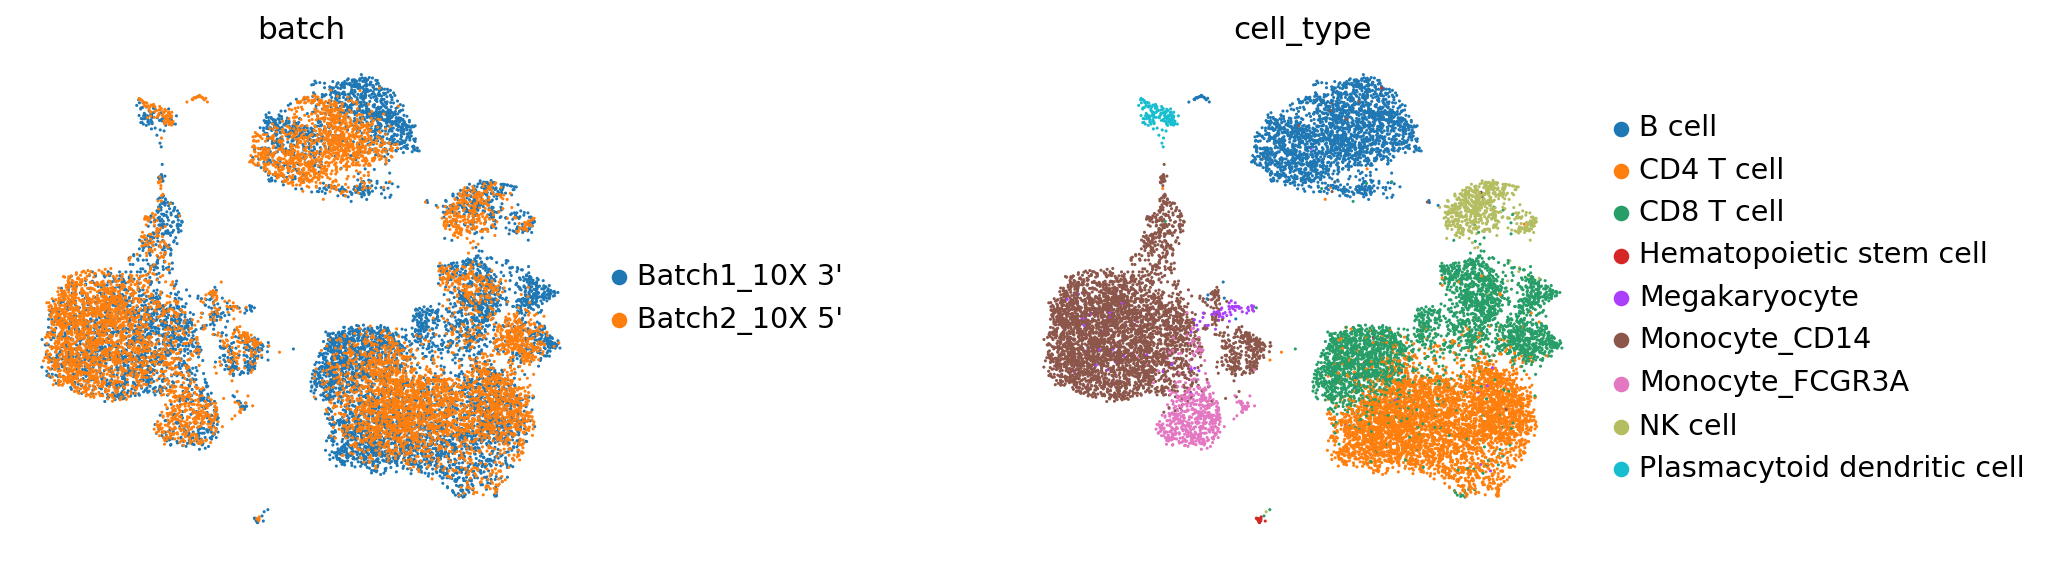

In [30]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

### Surgery pipeline for SCVI model

In [31]:
source_adata = orig_source_adata.copy()
target_adata = orig_target_adata.copy()

Preprocess reference dataset

In [32]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key)

INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8098 cells, 4000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Create the SCVI model instance.

In [33]:
scvi = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

Train the SCVI model instance.

In [34]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
scvi.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  42%|████▏     | 210/500 [01:55<02:28,  1.95it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  42%|████▏     | 210/500 [01:55<02:39,  1.81it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  80 s. / 500 epochs                                                  


Show latent representation of reference data.

In [35]:
reference_latent = sc.AnnData(scvi.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


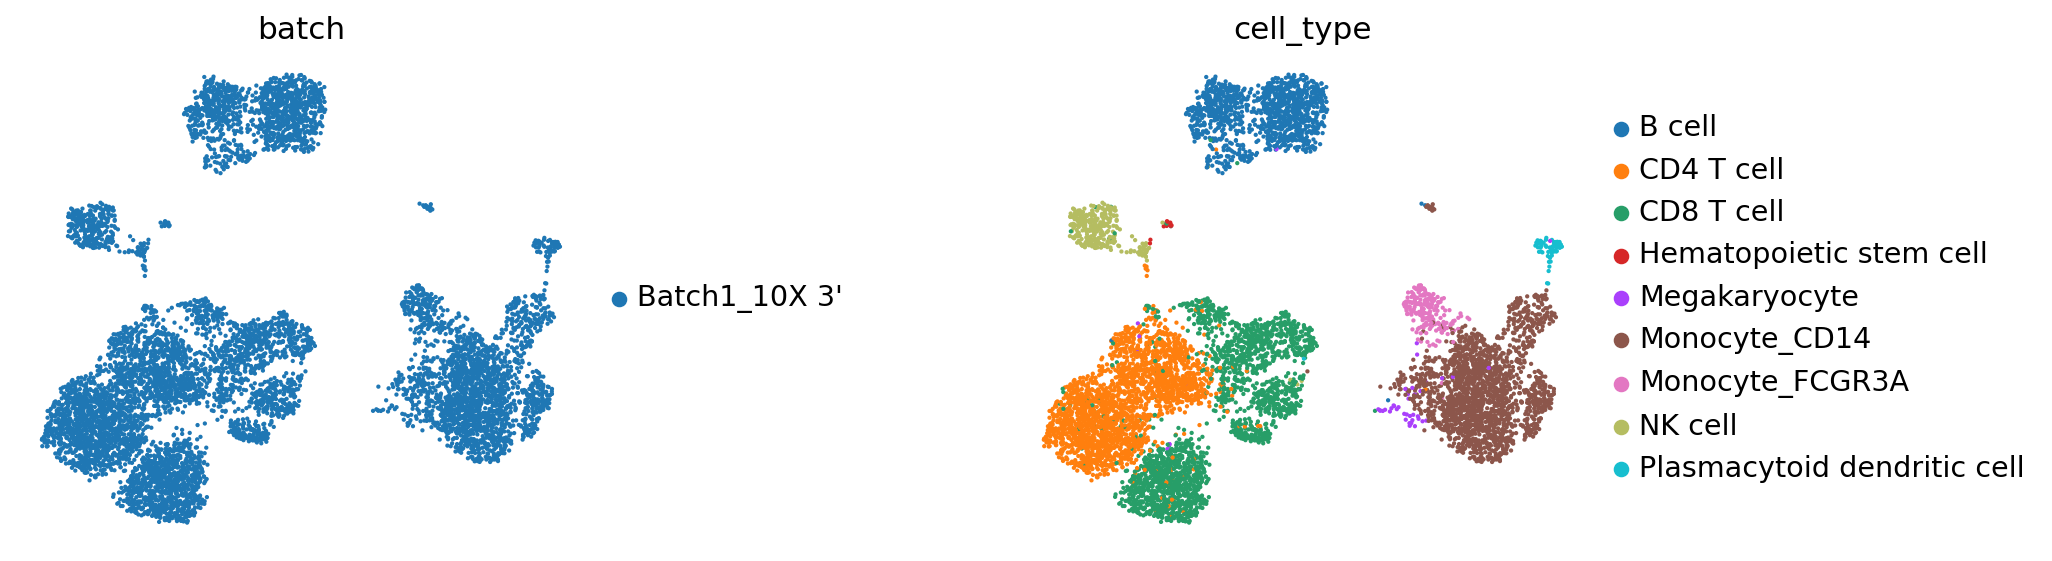

In [36]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

Do architecture surgery with the query dataset.

In [41]:
new_scvi = sca.models.SCVI.load_query_data(
    target_adata,
    scvi,
    freeze_dropout = True,
)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 7378 cells, 4000 vars, 2 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [42]:
new_scvi.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:   9%|▉         | 47/500 [00:20<03:09,  2.39it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:   9%|▉         | 47/500 [00:20<03:20,  2.26it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  13 s. / 500 epochs                                                  


Show latent representation of query data.

In [43]:
query_latent = sc.AnnData(new_scvi.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

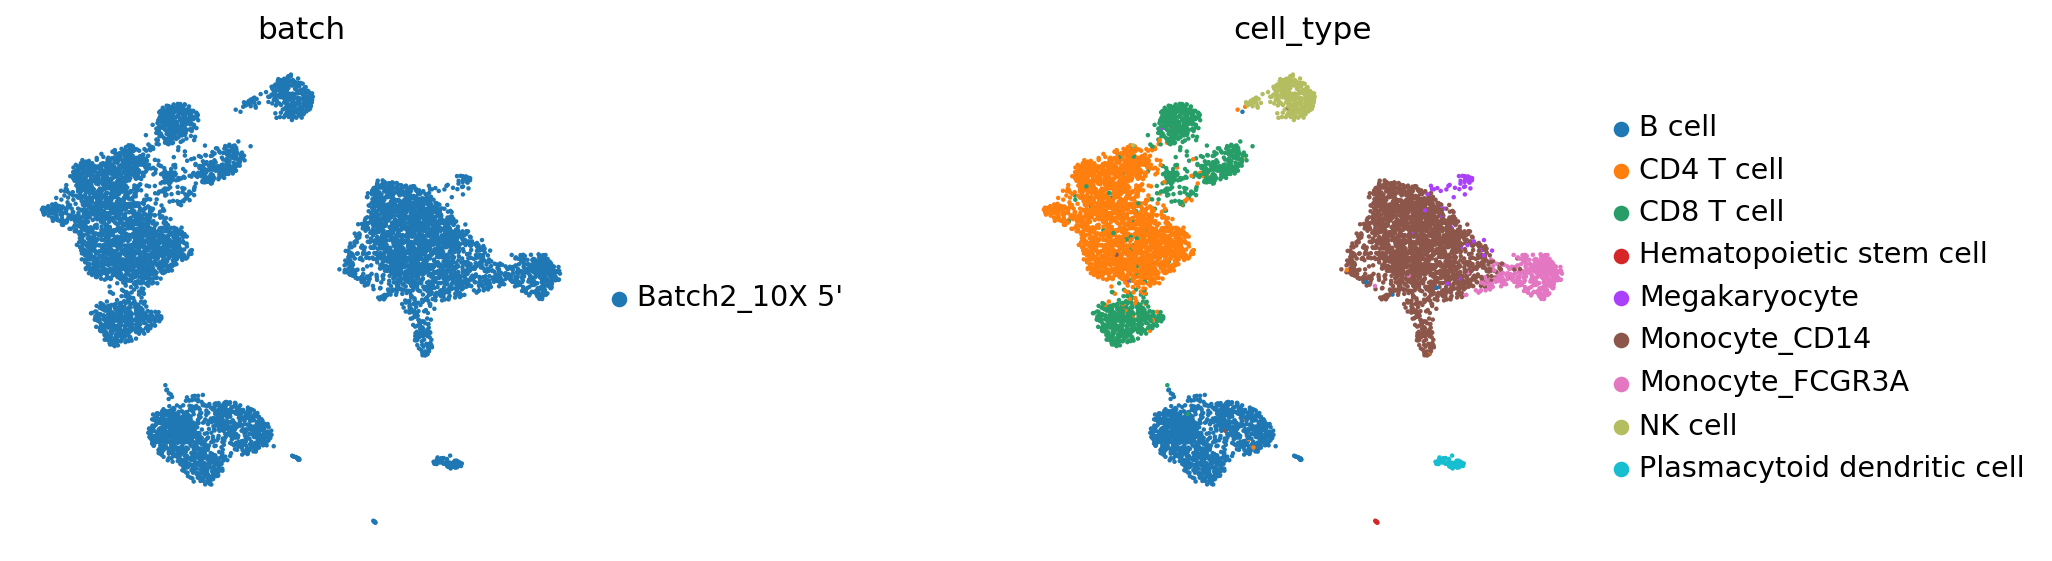

In [44]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

Show latent representation of reference + query data.

In [45]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(new_scvi.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15476 cells, 4000 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

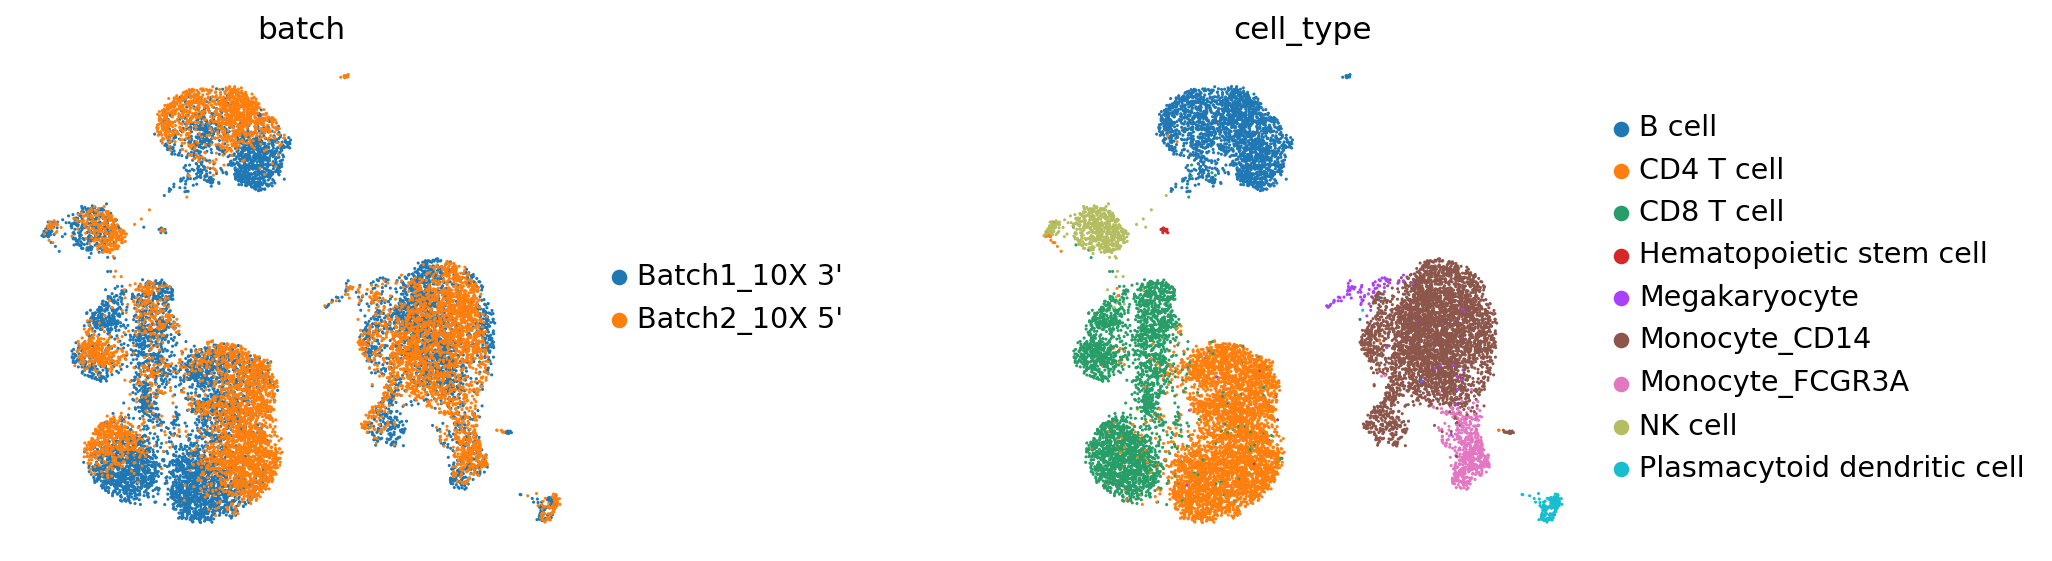

In [46]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Surgery pipeline for SCANVI model

In [47]:
source_adata = orig_source_adata.copy()
target_adata = orig_target_adata.copy()

Preprocess reference dataset.

In [48]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["CellType"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8098 cells, 4000 vars, 1 batches, 
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Create the SCANVI model instance.

In [49]:
scanvi = sca.models.SCANVI(
    source_adata,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [50]:
print("Labelled Indices: ", len(scanvi._labeled_indices))
print("Unlabelled Indices: ", len(scanvi._unlabeled_indices))

Labelled Indices:  8098
Unlabelled Indices:  0


Train the SCANVI model instance.

In [51]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
scanvi.train(
    n_epochs_unsupervised=500,
    n_epochs_semisupervised=200,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 200 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  46%|████▋     | 232/500 [02:07<02:24,  1.85it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  46%|████▋     | 232/500 [02:08<02:28,  1.81it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  87 s

Show latent representation of reference data.

In [52]:
reference_latent = sc.AnnData(scanvi.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


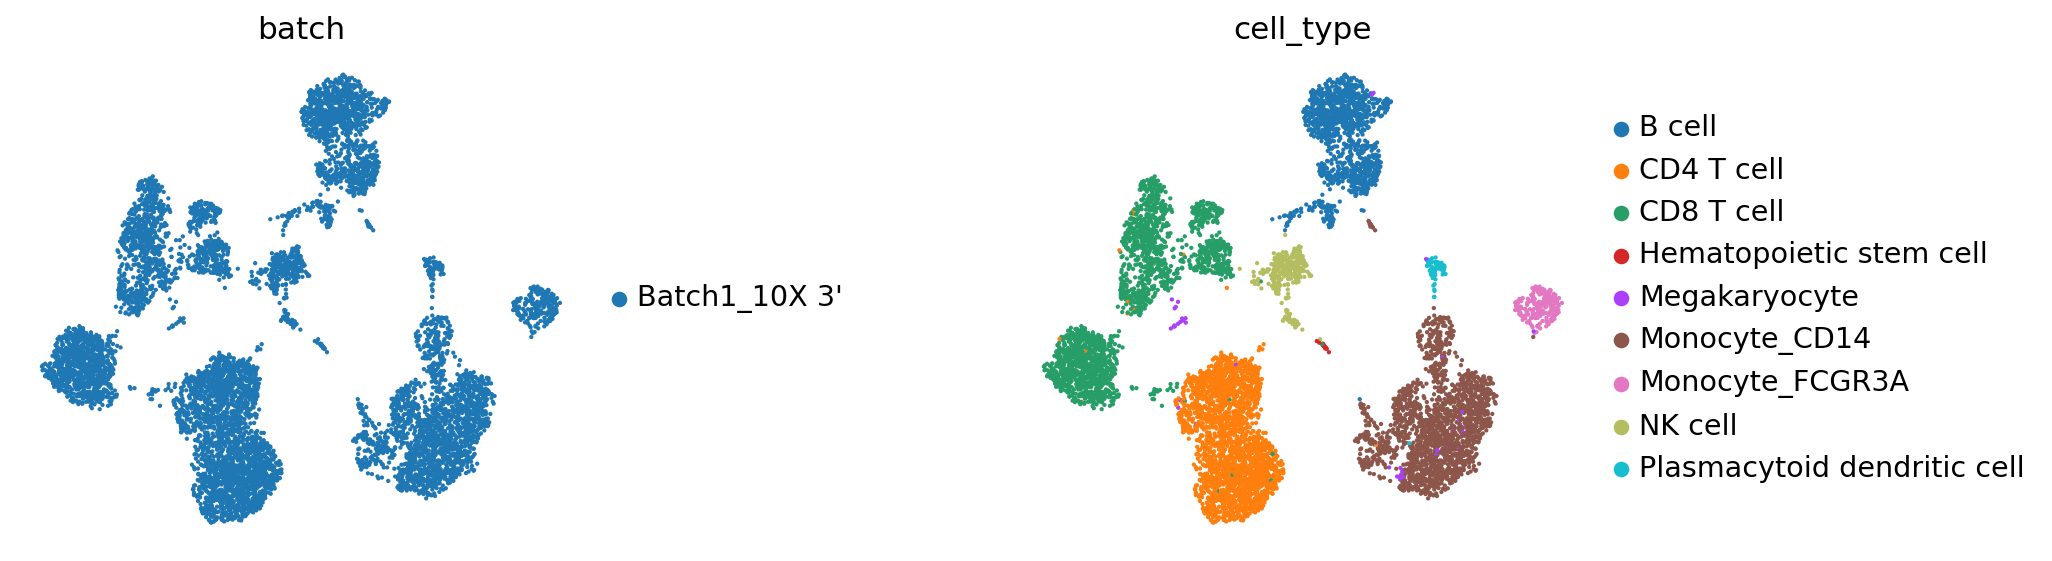

In [53]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [54]:
reference_latent.obs['predictions'] = scanvi.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9909854285008645


Do architecture surgery with the query dataset.

In [55]:
new_scanvi = sca.models.SCANVI.load_query_data(
    target_adata,
    scanvi,
    freeze_dropout = True,
)
new_scanvi._unlabeled_indices = np.arange(target_adata.n_obs)
new_scanvi._labeled_indices = []
print("Labelled Indices: ", len(new_scanvi._labeled_indices))
print("Unlabelled Indices: ", len(new_scanvi._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 7378 cells, 4000 vars, 2 batches, 
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
Labelled Indices:  0
Unlabelled Indices:  7378


In [56]:
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
new_scanvi.train(
    n_epochs_semisupervised=500,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  24%|██▎       | 118/500 [02:44<08:25,  1.32s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  24%|██▎       | 118/500 [02:45<08:57,  1.41s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  74 s

Show latent representation of query data.

In [57]:
query_latent = sc.AnnData(new_scanvi.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

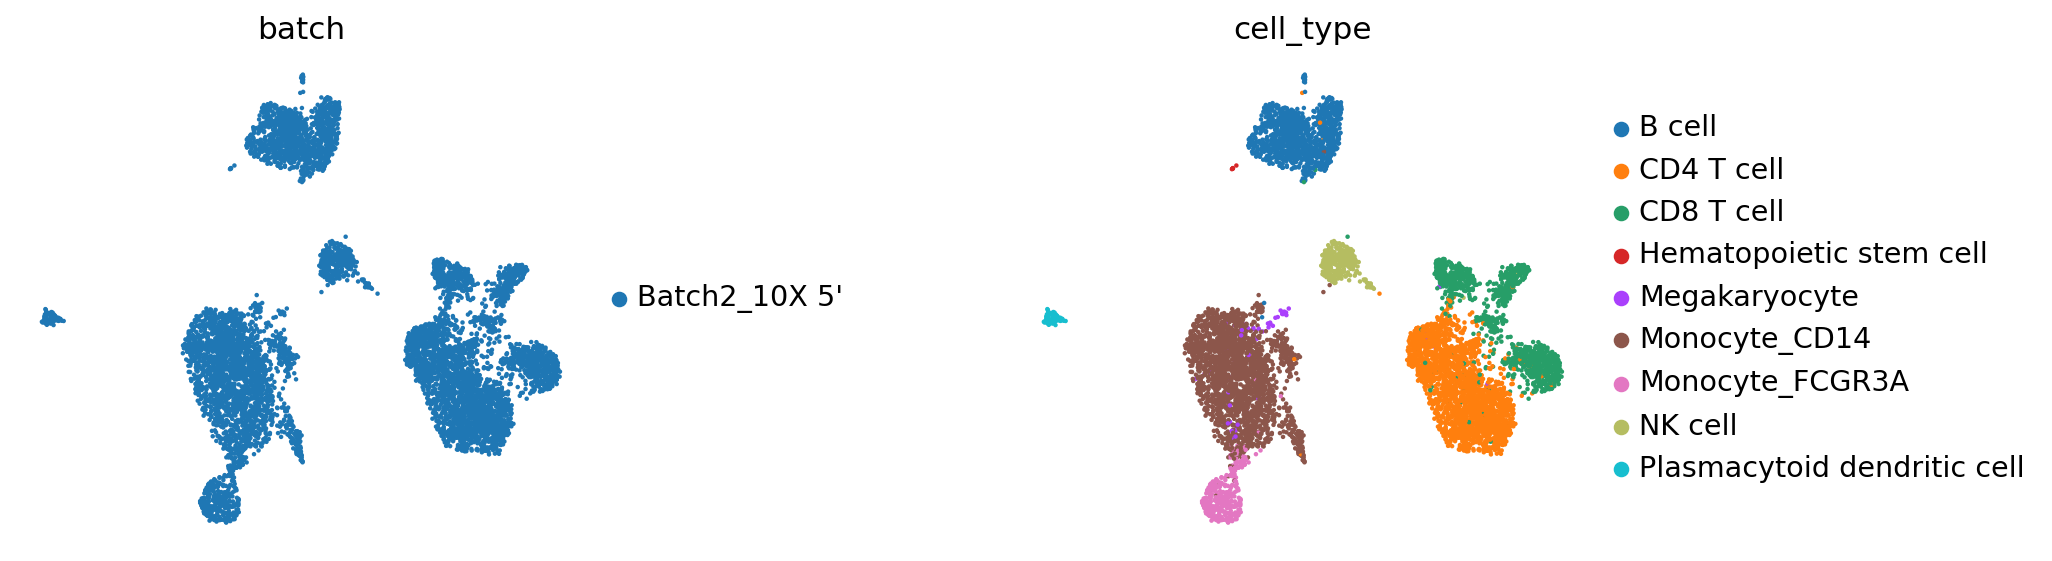

In [58]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [59]:
query_latent.obs['predictions'] = new_scanvi.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

Acc: 0.9596096503117376


Show latent representation of reference + query data.

In [60]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(new_scanvi.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15476 cells, 4000 vars, 2 batches,
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

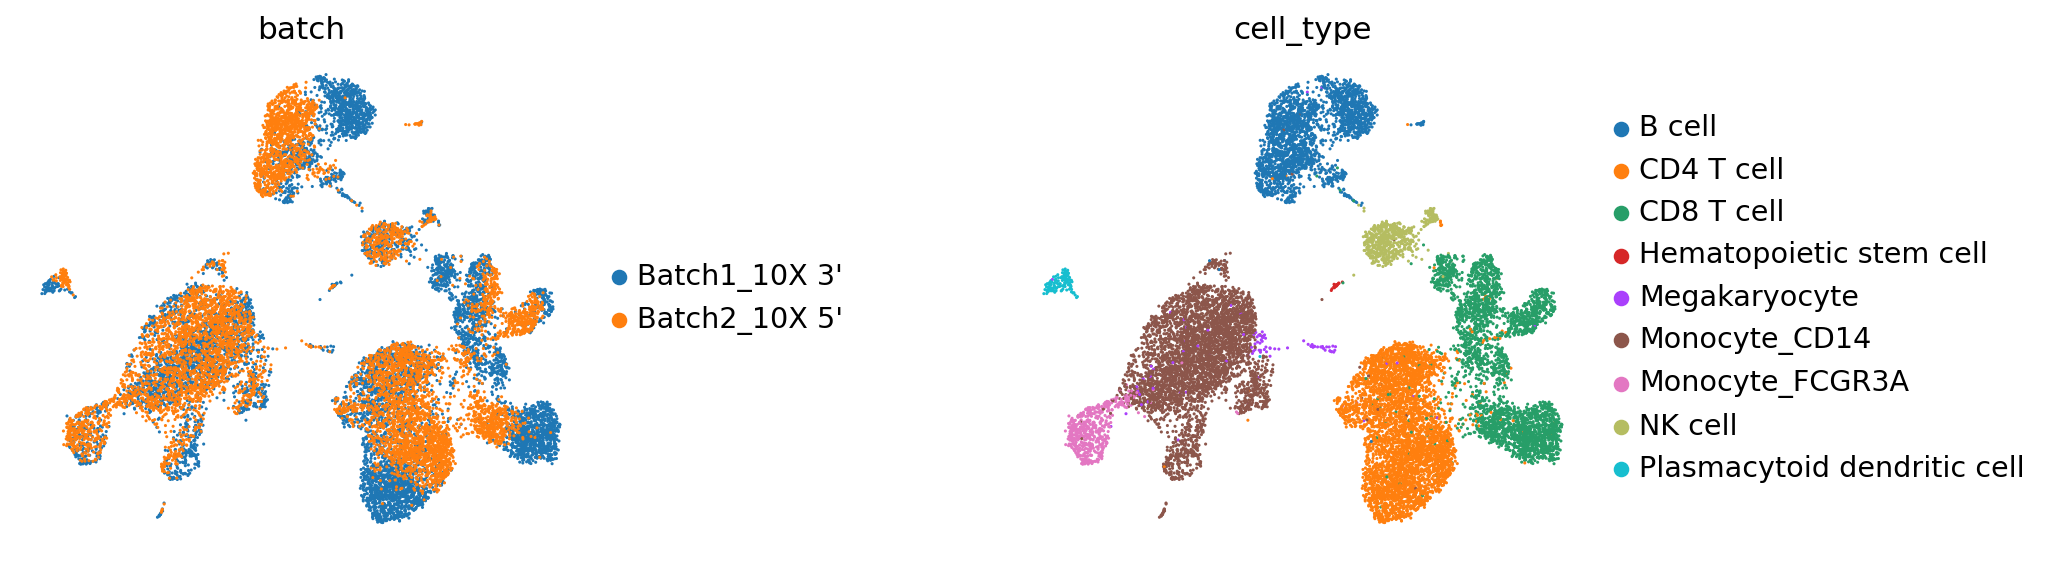

In [61]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [62]:
full_latent.obs['predictions'] = new_scanvi.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.cell_type)))

Acc: 0.976027397260274
